In [1]:
# !pip uninstall tensorflow keras -y
# !pip install tensorflow keras

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

random.seed(4)


2024-04-08 01:35:13.567393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 01:35:13.567500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 01:35:13.696621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pathlib

english_file_path = "/kaggle/input/translation-dataset/train.en"
nepali_file_path = "/kaggle/input/translation-dataset/train.ne"

output_file_path = "english_nepali_pairs.txt"  # Path for the output file

# Read the content of both files
with open(english_file_path, "r", encoding="utf-8") as en_file:
    english_lines = en_file.readlines()

with open(nepali_file_path, "r", encoding="utf-8") as ne_file:
    nepali_lines = ne_file.readlines()

# Ensure both files have the same number of lines
if len(english_lines) != len(nepali_lines):
    raise ValueError("English and Nepali files do not have the same number of lines.")

# Merge English and Nepali sentences into pairs
pairs = []
for en_line, ne_line in zip(english_lines, nepali_lines):
    # Strip any leading/trailing whitespace
    en_text = en_line.strip()
    ne_text = ne_line.strip()
    
    # Append English and Nepali sentences as a pair
    pairs.append((en_text, ne_text))

# Write pairs to the output file
with open(output_file_path, "w", encoding="utf-8") as output_file:
    for pair in pairs:
        output_file.write(pair[0] + "\t" + pair[1] + "\n")

# Now 'output_file_path' contains pairs of English and Nepali sentences in a tab-separated format


In [3]:
print(len(en_text))

37


In [4]:
text_file_path = "english_nepali_pairs.txt"

# Read the content of the file
with open(text_file_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

text_pairs = []
for line in lines:
    if line.strip():  # Check if the line is not empty
        eng, nep = line.split("\t",1)
        nep = "[start] " + nep + " [end]"
        text_pairs.append((eng, nep))

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('Although Ceylon Tea is one of Sri Lanka’s top exports, the industry has suffered heavy losses for a number of reasons, including climate change.', '[start] सिलोन चिया श्रीलंकाको प्रमुख निर्यातमध्ये एक भए तापनि यस उद्योगले प्रचुर मात्रामाा नोकसानी बेहोरेको छ जसका कारणमध्ये जलवायु परिवर्तन पनि एक रहेको छ। [end]')
('Unable to claim draw', '[start] खेल लोड गर्न असमर्थ [end]')
('Therefore behold, the days come, that I will execute judgment on the engraved images of Babylon; and her whole land shall be confounded; and all her slain shall fall in the midst of her.', '[start] निसन्देह समय आउने छ जब म बाबेलका झूटा देवताहरूलाई सजाय दिनेछु अनि बाबेलका सारा देश लाजले पानी हुनेछ। बाबेलका गल्लीहरूमा धैरे लाशहरू लडिरहेका हुनेछन्। [end]')
('Kathmandu , Jan. 14', '[start] काठमाण्डौं , जेठ १४ । [end]')
('Could Not Create Socket', '[start] सकेट सिर्जना गर्न सकेन [end]')


In [6]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

99999 total pairs
70001 training pairs
14999 validation pairs
14999 test pairs


In [7]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
nep_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_nep_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
nep_vectorization.adapt(train_nep_texts)

In [8]:
def format_dataset(eng, nep):
    eng = eng_vectorization(eng)
    nep = nep_vectorization(nep)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": nep[:, :-1],
        },
        nep[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, nep_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    nep_texts = list(nep_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, nep_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [9]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [10]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


In [11]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [12]:
import numpy as np
import nltk

# Define custom callback for calculating BLEU score
class BLEUCallback(keras.callbacks.Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds

    def on_epoch_end(self, epoch, logs=None):
        references = []
        candidates = []

        # Iterate over validation dataset and collect reference and candidate sentences
        for eng_batch, nep_batch in self.val_ds:
            eng_sentences = eng_vectorization.sequences_to_texts(eng_batch.numpy())
            nep_sentences = decode_sequence(eng_sentences)
            
            references.extend(nep_batch.numpy().tolist())
            candidates.extend(nep_vectorization.texts_to_sequences(nep_sentences))

        # Calculate BLEU score
        bleu_score = nltk.translate.bleu_score.corpus_bleu(references, candidates)

        print(f"Epoch {epoch+1} - BLEU Score: {bleu_score:.4f}")

# Create instance of the BLEU callback
bleu_callback = BLEUCallback(val_ds)

In [13]:
epochs = 20  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, None,      │ 12,959,640 │ decoder_inputs[0… │
│ (Functional)        │ 15000)            │            │ transformer_enco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
   3/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.1628 - loss: 9.1386       

I0000 00:00:1712540210.238686      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712540210.272959      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712540210.291708      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712540210.299398      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  53/1094 ━━━━━━━━━━━━━━━━━━━━ 3:31 203ms/step - accuracy: 0.4143 - loss: 6.3279

W0000 00:00:1712540220.730409      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712540220.749759      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5059 - loss: 4.1423

W0000 00:00:1712540256.212193      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - accuracy: 0.5060 - loss: 4.1416 - val_accuracy: 0.5609 - val_loss: 3.2327
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.5557 - loss: 3.2640 - val_accuracy: 0.5863 - val_loss: 2.8947
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.5771 - loss: 2.9578 - val_accuracy: 0.5917 - val_loss: 2.7554
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.5945 - loss: 2.7485 - val_accuracy: 0.6018 - val_loss: 2.6634
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.6040 - loss: 2.6426 - val_accuracy: 0.6107 - val_loss: 2.5901
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.6143 - loss: 2.5474 - val_accuracy: 0.6136 - val_loss: 2.5782
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.6235 - loss: 2.4813 - val_accuracy: 0.6133 - val_loss: 2.5889
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.6330 - loss: 2.41

In [14]:
spa_vocab = nep_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = nep_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
input_sentence = random.choice(test_eng_texts)
translated = decode_sequence(input_sentence)

print(input_sentence, translated)

the son of Michael, the son of Baaseiah, the son of Malchijah, [start] [UNK] [UNK] [UNK] छोरा थिए। [UNK] छोरा थिए। [end]


In [15]:
print(test_pairs[0])

('an audio file is played. You will be prompted to choose the file and set play options.', '[start] एउटा अडियो फाइल बजाइयो । तपाईँलाई फाइल छनोट गर्न र प्ले विकल्प सेट गर्न प्रोम्ट गरिन्छ । [end]')


In [2]:
from nltk.translate.bleu_score import sentence_bleu

bleus = []
for src, dest in test_pairs:
    dest = dest.split()
    dest = [word for word in dest if word not in ['[start]', '[end]', '[UNK]']]
    reference = [
        dest
    ]
    translated = decode_sequence(src)
    candidate = translated.split()
    candidate = [word for word in candidate if word not in ['[start]', '[end]', '[UNK]']]
    bleu = sentence_bleu(reference, candidate)
    bleus.append(bleu)

print(np.mean(bleus))

0.3602185447039022


In [32]:
for src, true_dest in test_pairs[10:20]:
    translated = decode_sequence(src)
    translated = translated.split()
    true_dest = true_dest.split()
    translated = [word for word in translated if word not in ['[start]', '[end]', '[UNK]']]
    true_dest = [word for word in true_dest if word not in ['[start]', '[end]', '[UNK]']]
    print(f"Input sentence: {src}\nTranslated: {' '.join(translated)}\nGround truth: {' '.join(true_dest)}\n")

Input sentence: Turn the cards over to find two numbers which subtract the same, until all the cards are gone.
Translated: सबै कार्डहरू जानु अघि दुई पटक कार्डहरू फर्काउनुहोस् जसले दुई पटक कार्डहरू जानु अघि प्रार्थना
Ground truth: सबै कार्डहरू जानु अघि, दुईवटा नम्बरहरू फेला पार्न कार्डहरू फर्काउनुहोस् जसले एउटै घटाउछ।

Input sentence: By faith, we understand that the universe has been framed by the word of God, so that what is seen has not been made out of things which are visible.
Translated: भन्ने के हो भन्ने के
Ground truth: विश्वासद्वारा हामी बुझ्दछौं कि परमेश्वरले आफ्नो आदेशद्वारा यो संसारको सृष्टि गर्नुभयो। यसले हामी बुझ्दछौ जो दृश्य छ त्यो कुनै अदृश्यद्वारा बनाइएको थियो।

Input sentence: They proclaimed a fast, and set Naboth on high among the people.
Translated: तिनीहरूले एउटा राम्रो र
Ground truth: अगुवाहरूले घोषणा गरे, एक दिन यस्तो हुनेछ जब सबै मानिसहरूले केही खाने छैनन्। त्यस दिन तिनीहरूले सबै मानिसहरूलाई एउटा सभामा बोलाए। तिनीहरूले नाबोतलाई मानिसहरूको अघि विशेष स्थानमा राखे।

# Save model

In [33]:
import tensorflow as tf

In [34]:
# Define the path where you want to save the weights
weights_path = "transformer_weights.h5"

# Save only the weights
transformer.save_weights('translate.weights.h5')

In [25]:
transformer.save("/kaggle/working/translate.keras")

In [35]:
translate = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [36]:
translate.load_weights("translate.weights.h5")

In [40]:
def decode_sequence_new(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = nep_vectorization([decoded_sentence])[:, :-1]
        predictions = translate([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [44]:
for src, true_dest in test_pairs[10:20]:
    translated = decode_sequence_new(src)
    translated = translated.split()
    true_dest = true_dest.split()
    translated = [word for word in translated if word not in ['[start]', '[end]', '[UNK]']]
    true_dest = [word for word in true_dest if word not in ['[start]', '[end]', '[UNK]']]
    print(f"Input sentence: {src}\nTranslated: {' '.join(translated)}\nGround truth: {' '.join(true_dest)}\n")

Input sentence: Turn the cards over to find two numbers which subtract the same, until all the cards are gone.
Translated: सबै कार्डहरू जानु अघि दुई पटक कार्डहरू फर्काउनुहोस् जसले दुई पटक कार्डहरू जानु अघि प्रार्थना
Ground truth: सबै कार्डहरू जानु अघि, दुईवटा नम्बरहरू फेला पार्न कार्डहरू फर्काउनुहोस् जसले एउटै घटाउछ।

Input sentence: By faith, we understand that the universe has been framed by the word of God, so that what is seen has not been made out of things which are visible.
Translated: भन्ने के हो भन्ने के
Ground truth: विश्वासद्वारा हामी बुझ्दछौं कि परमेश्वरले आफ्नो आदेशद्वारा यो संसारको सृष्टि गर्नुभयो। यसले हामी बुझ्दछौ जो दृश्य छ त्यो कुनै अदृश्यद्वारा बनाइएको थियो।

Input sentence: They proclaimed a fast, and set Naboth on high among the people.
Translated: तिनीहरूले एउटा राम्रो र
Ground truth: अगुवाहरूले घोषणा गरे, एक दिन यस्तो हुनेछ जब सबै मानिसहरूले केही खाने छैनन्। त्यस दिन तिनीहरूले सबै मानिसहरूलाई एउटा सभामा बोलाए। तिनीहरूले नाबोतलाई मानिसहरूको अघि विशेष स्थानमा राखे।

In [42]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize = (12, 12), dpi = 100)
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)
    plt.rcParams.update({'font.size': 20})
    plt.plot(epochs, loss, linewidth=2, label = "training_loss")
    plt.plot(epochs, val_loss, linewidth=2, label = "val_loss")
    plt.xlabel("Epoch", fontsize = 20)
    plt.ylabel("Loss", fontsize = 20)
    plt.title("Loss curve", fontsize = 20)
    plt.legend(prop={'size': 20})

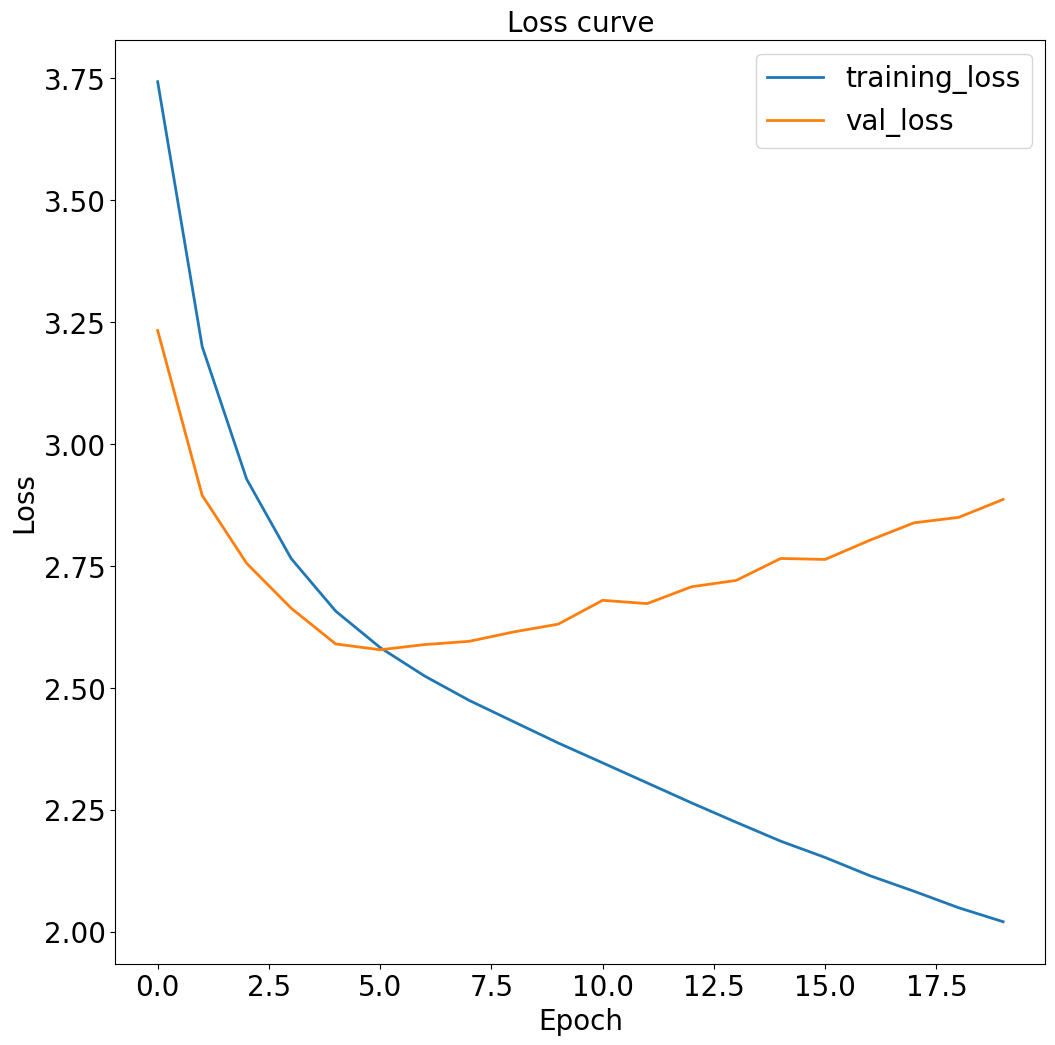

In [43]:
# en ne translation
plot_loss_curves(history)